In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.gan import *

## LSun bedroom data

For this lesson, we'll be using the bedrooms from the [LSUN dataset](http://lsun.cs.princeton.edu/2017/). The full dataset is a bit too large so we'll use a sample from [kaggle](https://www.kaggle.com/jhoward/lsun_bedroom).

In [3]:
path = untar_data(URLs.LSUN_BEDROOMS)

We then grab all the images in the folder with the data block API. We don't create a validation set here for reasons we'll explain later. It consists of random noise of size 100 by default (can be changed below) as inputs and the images of bedrooms as targets. That's why we do `tfm_y=True` in the transforms, then apply the normalization to the ys and not the xs.

In [4]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .no_split()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

We'll begin with a small side and use gradual resizing.

In [5]:
data = get_data(128, 64)

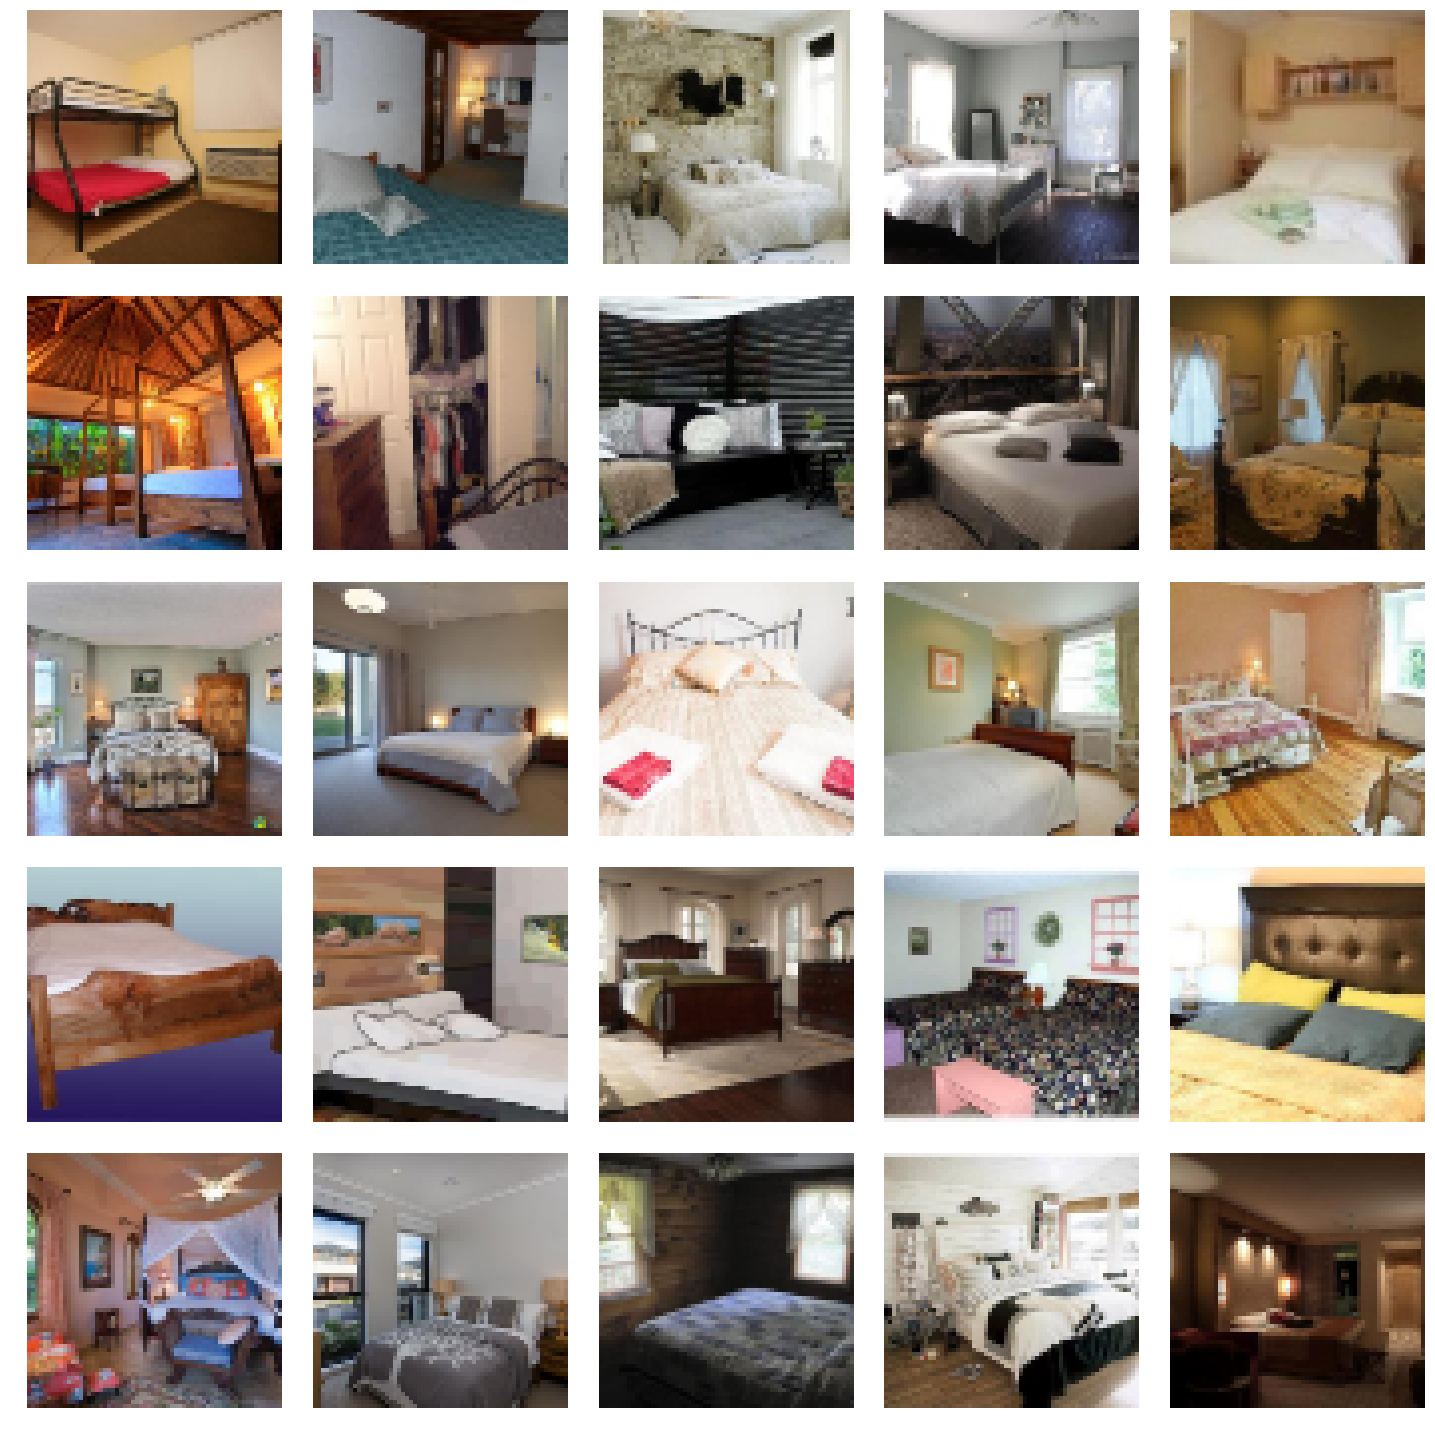

In [6]:
data.show_batch(rows=5)

## Models

GAN stands for [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf) and were invented by Ian Goodfellow. The concept is that we will train two models at the same time: a generator and a critic. The generator will try to make new images similar to the ones in our dataset, and the critic will try to classify real images from the ones the generator does. The generator returns images, the critic a single number (usually 0. for fake images and 1. for real ones).

We train them against each other in the sense that at each step (more or less), we:
1. Freeze the generator and train the critic for one step by:
  - getting one batch of true images (let's call that `real`)
  - generating one batch of fake images (let's call that `fake`)
  - have the critic evaluate each batch and compute a loss function from that; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the critic with the gradients of this loss
  
  
2. Freeze the critic and train the generator for one step by:
  - generating one batch of fake images
  - evaluate the critic on it
  - return a loss that rewards posisitivly the critic thinking those are real images; the important part is that it rewards positively the detection of real images and penalizes the fake ones
  - update the weights of the generator with the gradients of this loss
  
Here, we'll use the [Wassertein GAN](https://arxiv.org/pdf/1701.07875.pdf).

We create a generator and a critic that we pass to `gan_learner`. The noise_size is the size of the random vector from which our generator creates images.

In [6]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [7]:
#generator = models.basic_generator(in_size=64, n_channels=3, n_extra_layers=1, self_attention=True)
#discriminator = models.basic_discriminator(in_size=64, n_channels=3, n_extra_layers=1, self_attention=True)

In [8]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

epoch,train_loss,gen_loss,disc_loss
1,-0.921346,0.590369,-1.200837
2,-0.772808,0.555193,-1.037261
3,-0.839289,0.552206,-1.125746
4,-0.687911,0.470070,-0.909364
5,-0.582018,0.435939,-0.781826
6,-0.557278,0.447853,-0.774111
7,-0.548864,0.401715,-0.730585
8,-0.524185,0.370260,-0.707153
9,-0.470790,0.335274,-0.635272
10,-0.445610,0.327814,-0.596201


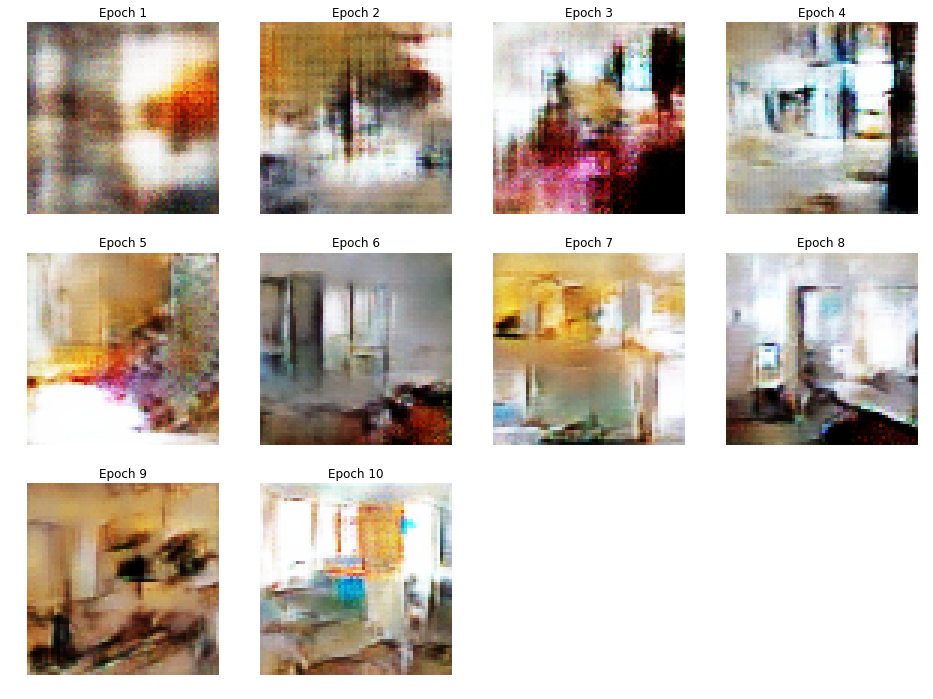

In [10]:
learn.fit(10,2e-4)

Let's go in generator mode and watch some results.

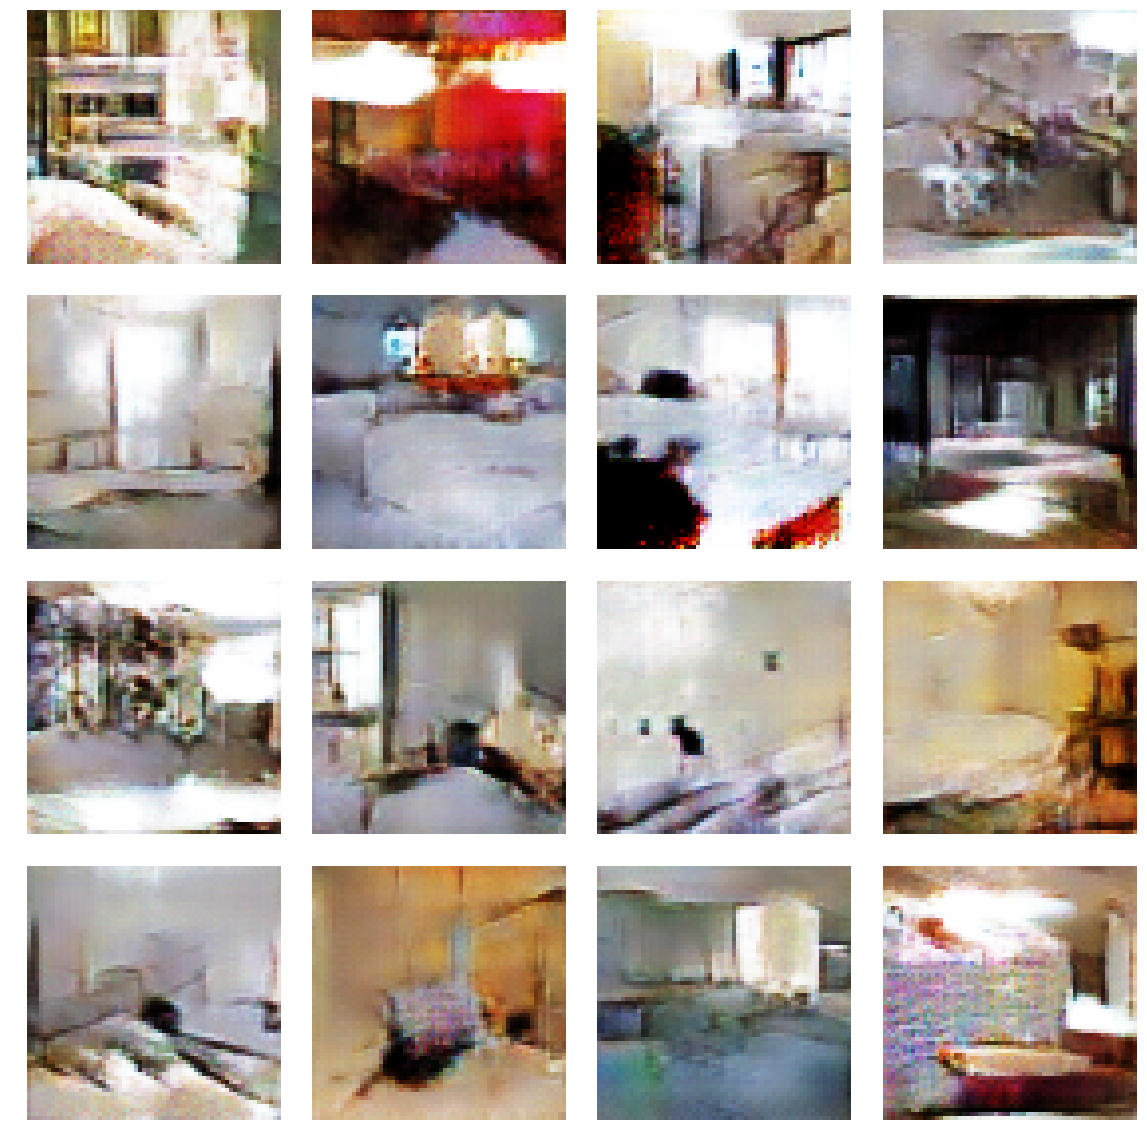

In [24]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16)